In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import NearestNeighbors
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.sparse.csgraph import minimum_spanning_tree
from pyclustering.cluster.kmedoids import kmedoids
from pyclustering.utils import calculate_distance_matrix
import networkx as nx
from kneed import KneeLocator
import random
import cvxpy as cp

In [ ]:
#!pip install networkx
#!pip install pyclustering

In [ ]:
#!pip install kneed

#### Clustering & MVO v.s. Clustering & Equal

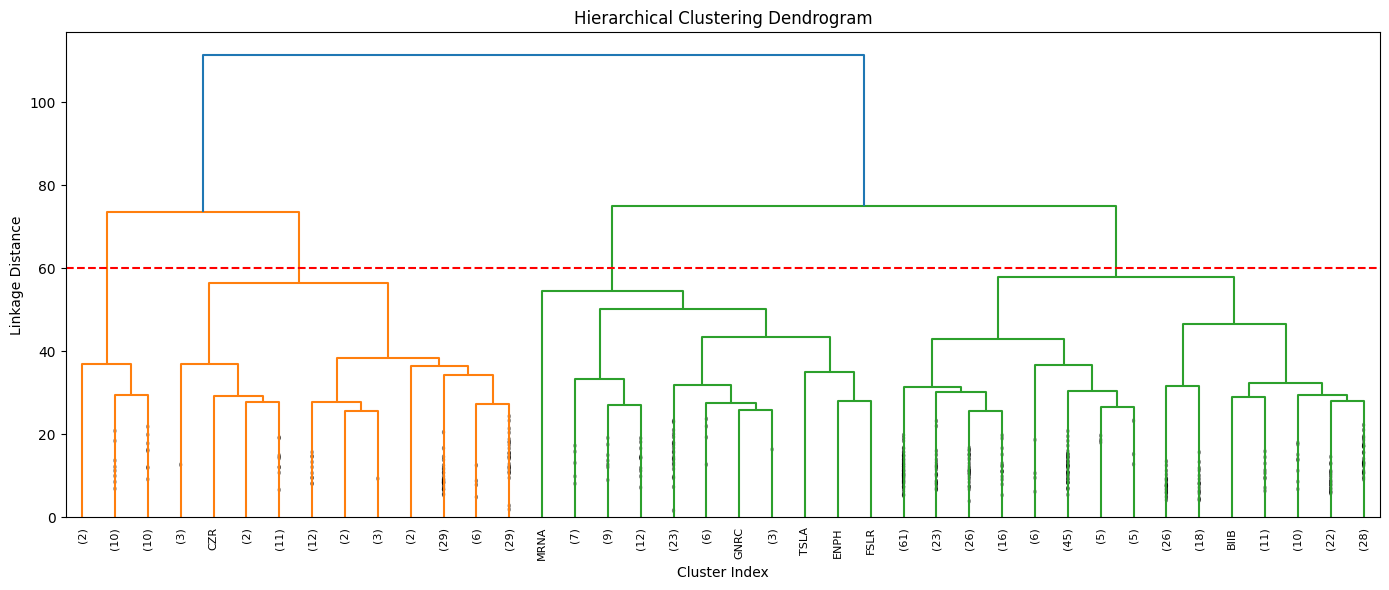

In [ ]:
# implement hierarchical clustering
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from sklearn.preprocessing import StandardScaler

ticker_data = pd.read_csv(r"C:\Users\guoqi\Desktop\sp500_ticker_data.csv", index_col=0, parse_dates=True) ## change path
benchmark_data = pd.read_csv(r"C:\Users\guoqi\Desktop\sp500_benchmark_data.csv", index_col=0, parse_dates=True) ## change path
ticker_data = ticker_data.dropna(axis=1)
benchmark_data = benchmark_data.dropna()
ticker_weekly = ticker_data.resample('W').last()
benchmark_weekly = benchmark_data.resample('W').last()


weekly_returns = ticker_weekly.pct_change().dropna()
features = weekly_returns.T
month_ends = weekly_returns.index.to_period('M').to_timestamp('M').unique()
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)
link = linkage(scaled_features, method='ward')
cluster_labels = fcluster(link, t=4, criterion='maxclust') # the number of clusters

plt.figure(figsize=(14, 6))
dendrogram(
    link,
    labels=features.index.tolist(),
    truncate_mode='lastp',   # Show only the last merged clusters (optional)
    p=40,                    # Show only the last 40 clusters (adjustable)
    leaf_rotation=90,
    show_contracted=True
)

# Optional: horizontal line to help identify clusters
plt.axhline(y=60, color='r', linestyle='--')  # Adjust 'y' as needed
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Cluster Index')
plt.ylabel('Linkage Distance')
plt.tight_layout()
plt.show()

In [ ]:
# Load uploaded data
ticker_data = pd.read_csv(r"C:\Users\guoqi\Desktop\sp500_ticker_data.csv", index_col=0, parse_dates=True)
benchmark_data = pd.read_csv(r"C:\Users\guoqi\Desktop\sp500_benchmark_data.csv", index_col=0, parse_dates=True)

# Weekly returns
weekly_prices = ticker_data.resample('W-FRI').last().dropna(axis=1, thresh=100)
weekly_returns = weekly_prices.pct_change().dropna()
benchmark_weekly_prices = benchmark_data.resample('W-FRI').last()
benchmark_weekly_returns = benchmark_weekly_prices.pct_change().dropna().squeeze()

def sharpe_ratio(returns, rf=0.01, freq=52):
    excess_ret = returns - (rf / freq)
    weekly_sharpe = excess_ret.mean() / excess_ret.std(ddof=1)
    return weekly_sharpe * np.sqrt(freq)  # Annualized

def mean_variance_opt(returns_df, rf=0.01, freq=52, risk_aversion=1.0):
    returns_df = returns_df.dropna(axis=1, how='any')
    if returns_df.shape[1] < 2 or returns_df.shape[0] < 4:
        raise ValueError("Not enough data")

    mu = returns_df.mean() * freq
    Sigma = returns_df.cov() * freq

    # Make symmetric + regularize for numerical stability
    Sigma = (Sigma + Sigma.T) / 2
    Sigma += np.eye(len(Sigma)) * 1e-6

    mu = mu.to_numpy()
    Sigma = Sigma.to_numpy()
    n = len(mu)

    w = cp.Variable(n)
    ret = mu @ w
    variance = cp.quad_form(w, Sigma)
    constraints = [cp.sum(w) == 1, w >= 0]
    prob = cp.Problem(cp.Maximize(ret - risk_aversion * variance), constraints)
    prob.solve()
    if w.value is None:
        raise ValueError("Solver failed")
    return np.array(w.value)

In [ ]:
n_clusters = 4
rolling_window = 3
month_ends = weekly_returns.index.to_period('M').to_timestamp('M').unique()
methods = ['KMeans', 'DBSCAN', 'GMM']

In [ ]:
top_n_per_cluster = 2
olivia_mvo_returns, olivia_eq_returns = [], []
for i in range(rolling_window, len(month_ends) - 1):
    train_start, train_end = month_ends[i-rolling_window] + timedelta(days=1), month_ends[i]
    test_start, test_end = month_ends[i] + timedelta(days=1), month_ends[i+1]
    train_data = weekly_returns.loc[train_start:train_end]
    test_data = weekly_returns.loc[test_start:test_end]
    if train_data.empty or test_data.empty: continue
    train_matrix = train_data.T
    labels = fcluster(linkage(StandardScaler().fit_transform(train_matrix), method='ward'), t=n_clusters, criterion='maxclust')
    cluster_labels = pd.Series(labels, index=train_matrix.index)
    sharpe_df = pd.DataFrame({'Ticker': train_matrix.index, 'Sharpe': [sharpe_ratio(train_data[t]) for t in train_matrix.index]})
    top_stocks = pd.merge(cluster_labels.rename('Cluster'), sharpe_df, left_index=True, right_on='Ticker').sort_values('Sharpe', ascending=False).groupby('Cluster').head(2)
    valid = [t for t in top_stocks['Ticker'] if t in test_data.columns and t in train_data.columns]
    if len(valid) < 2: continue
    try:
        w = mean_variance_opt(train_data[valid])
        olivia_mvo_returns.append(test_data[valid] @ w)
        olivia_eq_returns.append(test_data[valid].mean(axis=1))
    except: continue

In [ ]:
## PAM Strategy
pam_mvo_returns = []
pam_eq_returns = []

for i in range(rolling_window, len(month_ends) - 1):
    train_start, train_end = month_ends[i-rolling_window] + timedelta(days=1), month_ends[i]
    test_start, test_end = month_ends[i] + timedelta(days=1), month_ends[i+1]
    train_data = weekly_returns.loc[train_start:train_end]
    test_data = weekly_returns.loc[test_start:test_end]

    if train_data.empty or test_data.empty:
        print(f"Skipped period {train_start.date()} - {train_end.date()}: Empty train/test data")
        continue

    if train_data.shape[0] < 4 or train_data.shape[1] < n_clusters:
        print(f"Skipped period {train_start.date()} - {train_end.date()}: Not enough time points or stocks")
        continue

    train_matrix = train_data.T
    scaled = StandardScaler().fit_transform(train_matrix)

    if scaled.shape[0] < n_clusters:
        print(f"Skipped period {train_start.date()} - {train_end.date()}: Too few stocks for clustering")
        continue

    try:
        initial_medoids = random.sample(range(scaled.shape[0]), n_clusters)
        distance_matrix = calculate_distance_matrix(scaled)
        pam_instance = kmedoids(distance_matrix, initial_medoids, data_type='distance_matrix')
        pam_instance.process()
        clusters = pam_instance.get_clusters()

        labels = np.empty(scaled.shape[0], dtype=int)
        for cluster_id, cluster in enumerate(clusters, start=1):
            for idx in cluster:
                labels[idx] = cluster_id
    except Exception as e:
        print(f"Clustering failed: {e}")
        continue

    cluster_labels = pd.Series(labels, index=train_matrix.index, name='Cluster')

    sharpe_df = pd.DataFrame({
        'Ticker': train_matrix.index,
        'Sharpe': [sharpe_ratio(train_data[t]) for t in train_matrix.index]
    })

    cluster_df = cluster_labels.rename_axis('Ticker').reset_index()
    combined_df = pd.merge(cluster_df, sharpe_df, on='Ticker')

    top_stocks = combined_df.sort_values(by='Sharpe', ascending=False).groupby('Cluster').head(top_n_per_cluster)

    selected_tickers = top_stocks['Ticker'].tolist()
    valid_tickers = [t for t in selected_tickers if t in train_data.columns and t in test_data.columns]

    if len(valid_tickers) < 2:
        print(f"Skipped period {train_start.date()} - {train_end.date()}: Not enough valid tickers ({len(valid_tickers)})")
        continue

    train_subset = train_data[valid_tickers]
    test_subset = test_data[valid_tickers]

    try:
        weights = mean_variance_opt(train_subset)
        weighted_returns = test_subset @ weights
        equal_returns = test_subset.mean(axis=1)

        pam_mvo_returns.append(weighted_returns)
        pam_eq_returns.append(equal_returns)
    except Exception as e:
        print(f"Optimization failed: {e}")
        continue

print(f"✅ PAM MVO returns collected: {len(pam_mvo_returns)}")
print(f"✅ PAM Equal returns collected: {len(pam_eq_returns)}")

✅ PAM MVO returns collected: 32
✅ PAM Equal returns collected: 32


In [ ]:
kathy_mvo_returns = {m: [] for m in methods}
kathy_eq_returns = {m: [] for m in methods}
for i in range(rolling_window, len(month_ends) - 1):
    train_start, train_end = month_ends[i-rolling_window] + timedelta(days=1), month_ends[i]
    test_start, test_end = month_ends[i] + timedelta(days=1), month_ends[i+1]
    train, test = weekly_returns.loc[train_start:train_end], weekly_returns.loc[test_start:test_end]
    if train.shape[0] < 4 or test.empty: continue
    feats = train.T
    Xs = StandardScaler().fit_transform(feats)
    wcss = [KMeans(n_clusters=k, random_state=0, n_init=5).fit(Xs).inertia_ for k in range(1, 11)]
    k_opt = KneeLocator(range(1, 11), wcss, curve="convex", direction="decreasing").elbow or 4
    nbrs = NearestNeighbors(n_neighbors=3).fit(Xs)
    dists, _ = nbrs.kneighbors(Xs)
    d = np.sort(dists[:, 2])
    eps_opt = KneeLocator(range(len(d)), d, curve="convex", direction="increasing").knee or np.percentile(d, 90)
    labels = pd.DataFrame(index=feats.index)
    labels['KMeans'] = KMeans(n_clusters=k_opt, random_state=0, n_init=5).fit_predict(Xs)
    labels['DBSCAN'] = DBSCAN(eps=eps_opt, min_samples=3).fit_predict(Xs)
    labels['GMM'] = GaussianMixture(n_components=k_opt, random_state=0).fit_predict(Xs)
    sharpe = train.mean() / train.std(ddof=1) * np.sqrt(52)
    for m in methods:
        picks = set()
        for c in np.unique(labels[m]):
            if c == -1: continue
            members = labels.index[labels[m] == c]
            picks.update(sharpe.loc[members].nlargest(2).index)
        valid = [t for t in picks if t in train.columns and t in test.columns]
        if len(valid) < 2: continue
        try:
            w = mean_variance_opt(train[valid])
            kathy_mvo_returns[m].append(test[valid] @ w)
            kathy_eq_returns[m].append(test[valid].mean(axis=1))
        except: continue


In [ ]:
#Rolling-window MST strategy
weihang_mst_mvo_returns, weihang_mst_eq_returns = [], []
mst_selected_tickers = []
for i in range(rolling_window, len(month_ends) - 1):
    train_start = month_ends[i-rolling_window] + timedelta(days=1)
    train_end   = month_ends[i]
    test_start  = month_ends[i] + timedelta(days=1)
    test_end    = month_ends[i+1]
    train = weekly_returns.loc[train_start:train_end]
    test  = weekly_returns.loc[test_start:test_end]
    if train.empty or test.empty or train.shape[0] < 4:
        continue
    #build MST on train
    corr   = train.corr().values
    dist   = np.sqrt(2*(1-corr))
    mst    = minimum_spanning_tree(dist)
    coo    = mst.tocoo()
    #average edge-weight per node
    node_w = {n:[] for n in range(train.shape[1])}
    for u,v,w in zip(coo.row, coo.col, coo.data):
        node_w[u].append(w); node_w[v].append(w)
    avg_w = np.array([np.mean(node_w[n]) if node_w[n] else 0
                      for n in range(train.shape[1])])
    #pick top-11
    top_idx = np.argsort(avg_w)[-11:]
    tickers_sel = train.columns[top_idx]
    mst_selected_tickers.append(list(tickers_sel))
    #Equal-weight returns
    weihang_mst_eq_returns.append(test[tickers_sel].mean(axis=1))
    #MVO on those 11
    try:
        w = mean_variance_opt(train[tickers_sel])
        weihang_mst_mvo_returns.append(test[tickers_sel] @ w)
    except:
        continue


C:\Users\guoqi\AppData\Local\Temp\ipykernel_37848\3843110312.py:31: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  benchmark_series = (1 + benchmark_weekly_returns).reindex(full_index).fillna(method='ffill')


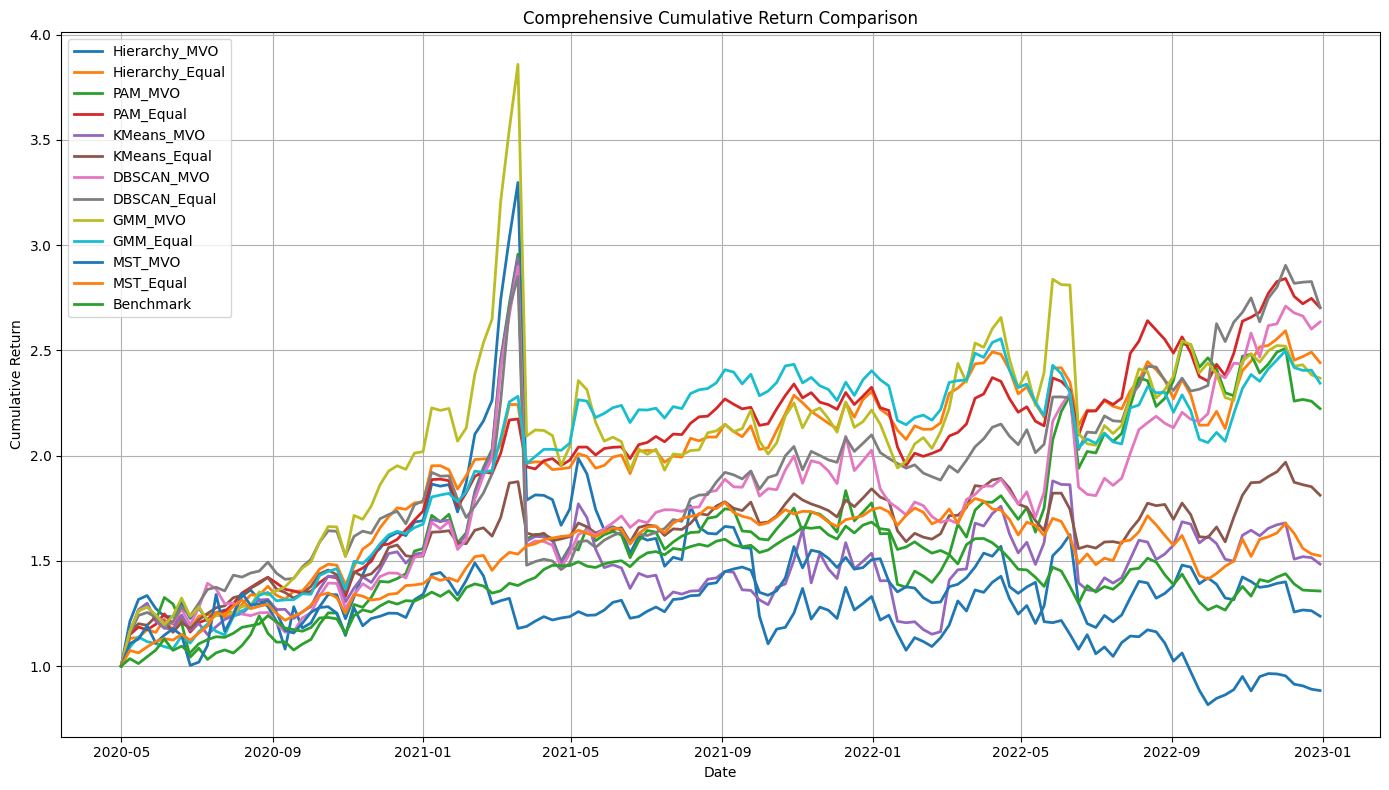


📊 Strategy Performance Metrics:
       Strategy  Annualized Sharpe  Annualized Volatility  Max Drawdown  Annualized Sortino   CAGR  Calmar Ratio
      PAM_Equal              1.565                  0.252        -0.165               2.368  0.447         2.699
Hierarchy_Equal              1.383                  0.259        -0.146               2.144  0.393         2.686
      GMM_Equal              1.283                  0.269        -0.203               1.852  0.372         1.836
   DBSCAN_Equal              1.111                  0.427        -0.489               0.996  0.447         0.915
     DBSCAN_MVO              1.023                  0.470        -0.494               1.048  0.433         0.877
   KMeans_Equal              0.931                  0.266        -0.176               1.389  0.247         1.400
        GMM_MVO              0.915                  0.497        -0.500               0.935  0.377         0.755
        PAM_MVO              0.859                  0.505      

In [ ]:
# Plotting
all_series = (
    olivia_mvo_returns + olivia_eq_returns +
    pam_mvo_returns + pam_eq_returns +
    kathy_mvo_returns['KMeans'] + kathy_eq_returns['KMeans'] +
    kathy_mvo_returns['DBSCAN'] + kathy_eq_returns['DBSCAN'] +
    kathy_mvo_returns['GMM']    + kathy_eq_returns['GMM']    +
    weihang_mst_mvo_returns     + weihang_mst_eq_returns
)
full_index = pd.concat(all_series).index.unique().sort_values()
cum_df = pd.DataFrame(index=full_index)

def add_strategy(df, name, series_list):
    if series_list:
        series = pd.concat(series_list).sort_index().fillna(0)
        df[name] = (1 + series).cumprod()

add_strategy(cum_df, 'Hierarchy_MVO', olivia_mvo_returns)
add_strategy(cum_df, 'Hierarchy_Equal', olivia_eq_returns)
add_strategy(cum_df, 'PAM_MVO', pam_mvo_returns)
add_strategy(cum_df, 'PAM_Equal', pam_eq_returns)
add_strategy(cum_df, 'KMeans_MVO', kathy_mvo_returns['KMeans'])
add_strategy(cum_df, 'KMeans_Equal', kathy_eq_returns['KMeans'])
add_strategy(cum_df, 'DBSCAN_MVO', kathy_mvo_returns['DBSCAN'])
add_strategy(cum_df, 'DBSCAN_Equal', kathy_eq_returns['DBSCAN'])
add_strategy(cum_df, 'GMM_MVO', kathy_mvo_returns['GMM'])
add_strategy(cum_df, 'GMM_Equal', kathy_eq_returns['GMM'])
add_strategy(cum_df, 'MST_MVO', weihang_mst_mvo_returns)
add_strategy(cum_df, 'MST_Equal', weihang_mst_eq_returns)

benchmark_series = (1 + benchmark_weekly_returns).reindex(full_index).fillna(method='ffill')
cum_df['Benchmark'] = benchmark_series.cumprod()
cum_df = cum_df / cum_df.iloc[0]

plt.figure(figsize=(14, 8))
for col in cum_df.columns:
    plt.plot(cum_df.index, cum_df[col], label=col, linewidth=2)
plt.title("Comprehensive Cumulative Return Comparison")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# =======================================
# Performance Metrics (Sharpe, Volatility, Max Drawdown, etc.)
# =======================================

def sharpe_ratio(returns, rf=0.01, freq=52):
    excess_ret = returns - (rf / freq)
    weekly_sharpe = excess_ret.mean() / excess_ret.std(ddof=1)
    return weekly_sharpe * np.sqrt(freq)  # Annualized

def sortino_ratio(returns, rf=0.01, freq=52):
    excess = returns - (rf / freq)
    downside_std = excess[excess < 0].std(ddof=1)
    weekly_sortino = excess.mean() / downside_std if downside_std != 0 else np.nan
    return weekly_sortino * np.sqrt(freq)  # Annualized

def volatility(returns, freq=52):
    return returns.std(ddof=1) * np.sqrt(freq)  # Annualized

def max_drawdown(cum_returns):
    peak = cum_returns.cummax()
    dd = (cum_returns - peak) / peak
    return dd.min()

def cagr(cum_returns, freq=52):
    total_periods = len(cum_returns)
    if total_periods < 2:
        return np.nan
    years = total_periods / freq
    return (cum_returns.iloc[-1] / cum_returns.iloc[0])**(1 / years) - 1

# Compute metrics for each strategy
metrics = []
for col in cum_df.columns:
    cum = cum_df[col]
    ret = cum.pct_change().dropna()

    sr = sharpe_ratio(ret)
    srt = sortino_ratio(ret)
    vol = volatility(ret)
    mdd = max_drawdown(cum)
    growth = cagr(cum)
    calmar = growth / abs(mdd) if mdd != 0 else np.nan

    metrics.append([col, sr, vol, mdd, srt, growth, calmar])

metrics_df = pd.DataFrame(metrics, columns=[
    "Strategy", "Annualized Sharpe", "Annualized Volatility", "Max Drawdown",
    "Annualized Sortino", "CAGR", "Calmar Ratio"
])

metrics_df = metrics_df.sort_values(by="Annualized Sharpe", ascending=False)

print("\n📊 Strategy Performance Metrics:")
print(metrics_df.to_string(index=False, float_format="%.3f"))

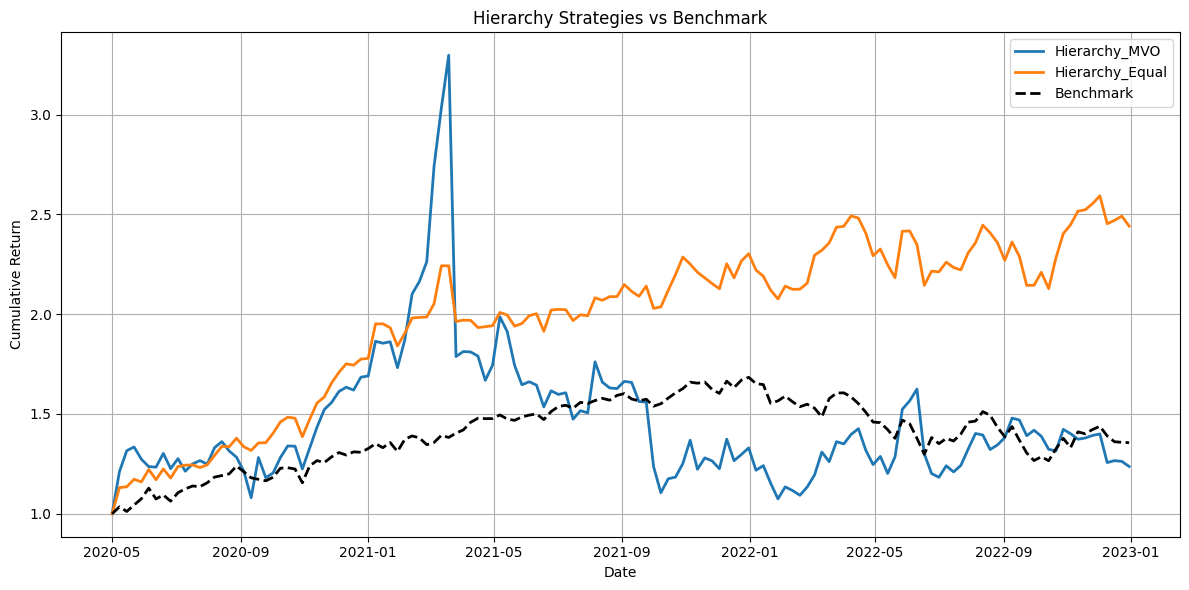

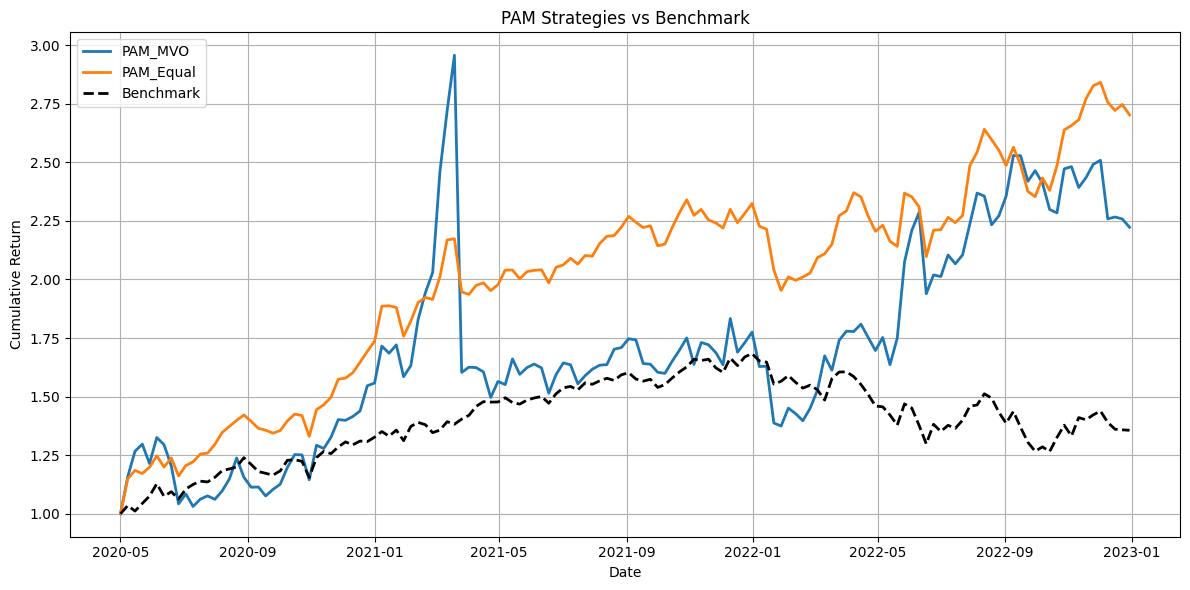

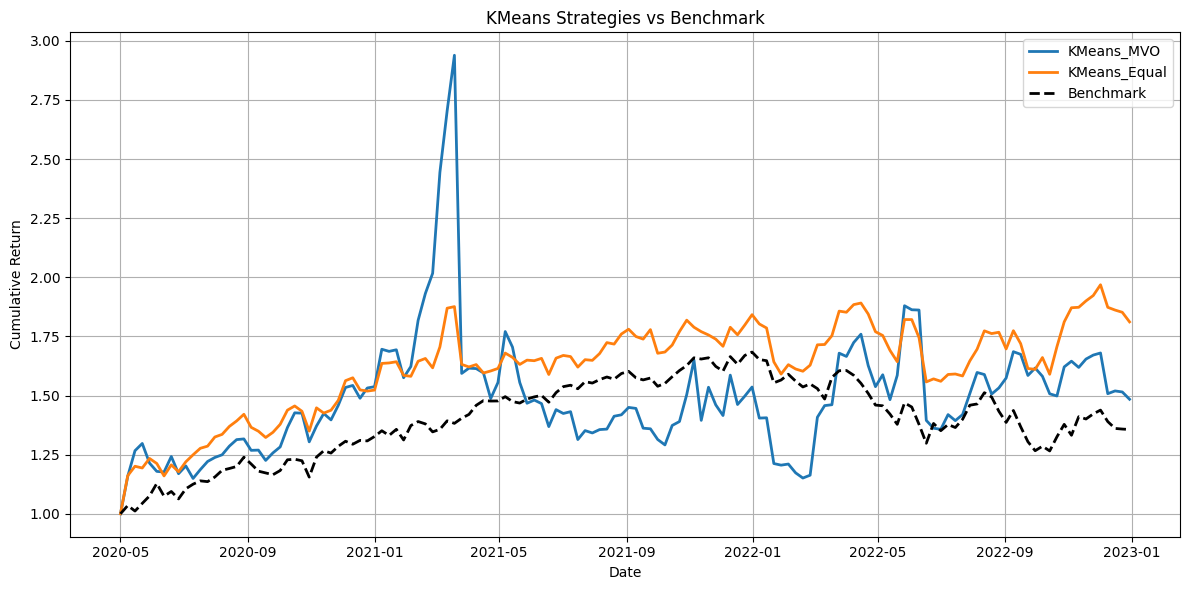

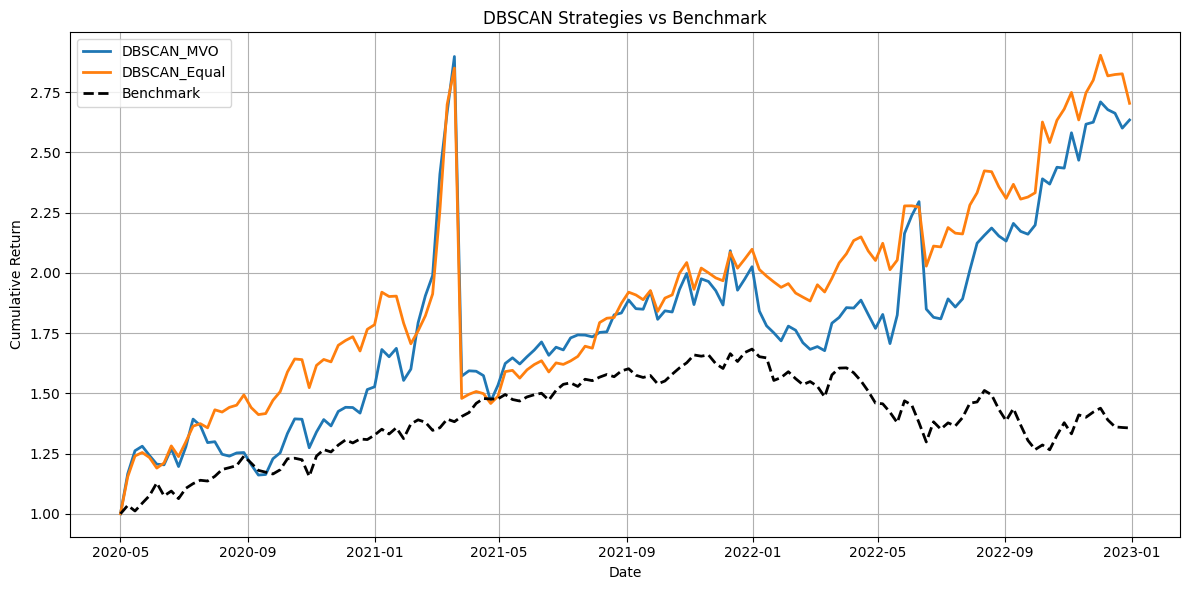

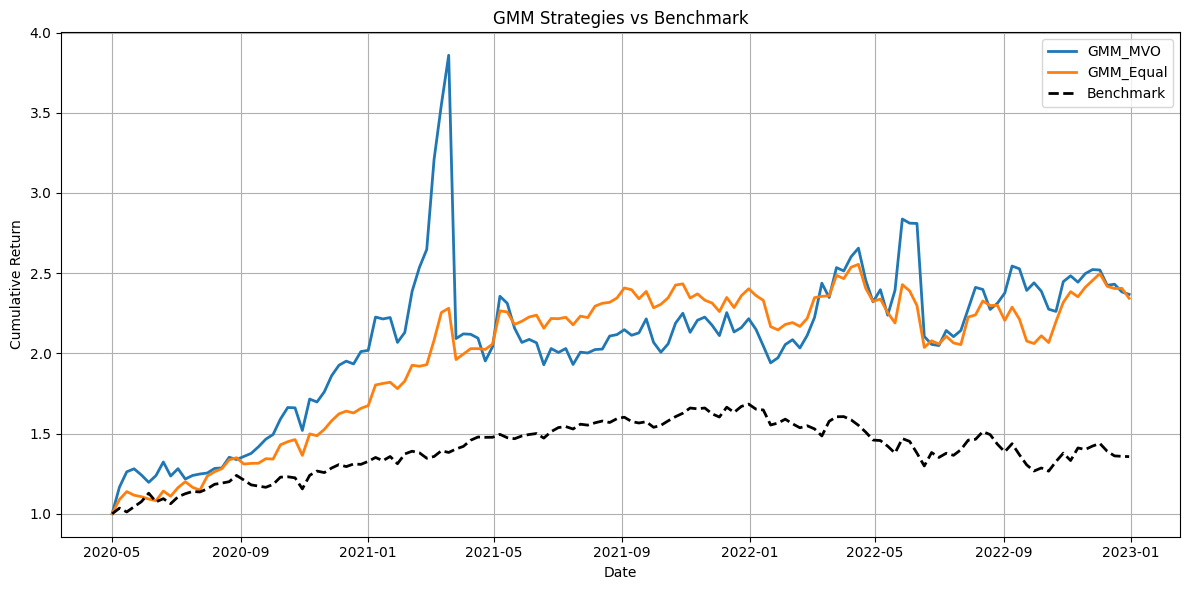

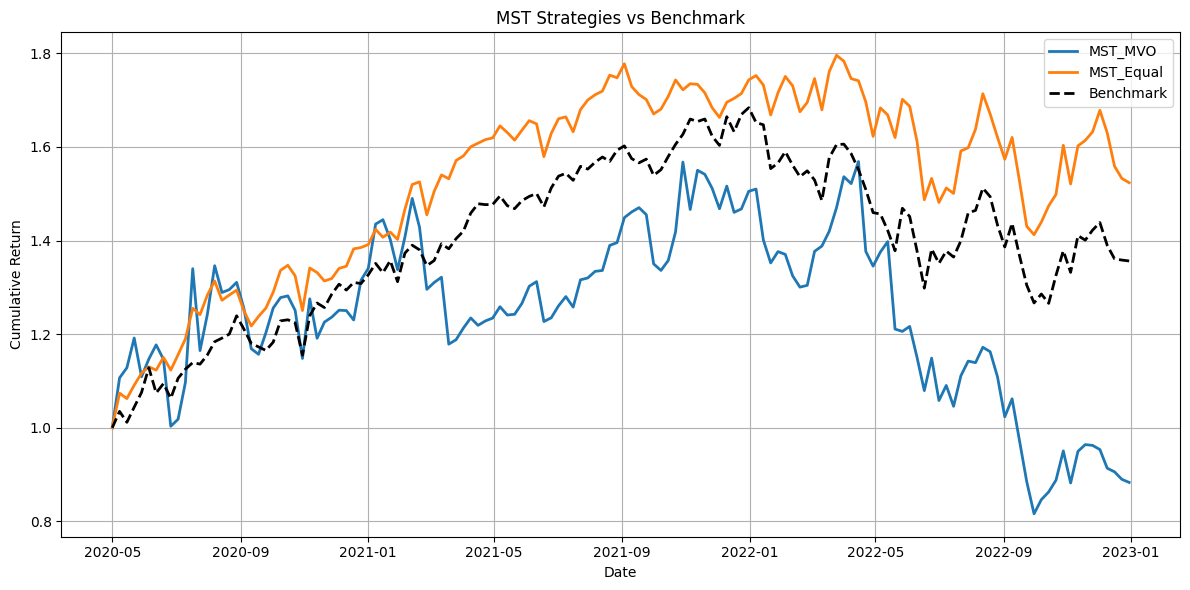

In [ ]:
# === Group strategies ===
plot_groups = {
    "Hierarchy": ["Hierarchy_MVO", "Hierarchy_Equal"],
    "PAM": ["PAM_MVO", "PAM_Equal"],
    "KMeans": ["KMeans_MVO", "KMeans_Equal"],
    "DBSCAN": ["DBSCAN_MVO", "DBSCAN_Equal"],
    "GMM": ["GMM_MVO", "GMM_Equal"],
    "MST": ["MST_MVO", "MST_Equal"],
}

benchmark_series = cum_df['Benchmark']

for group_name, strategies in plot_groups.items():
    plt.figure(figsize=(12, 6))
    for strategy in strategies:
        if strategy in cum_df.columns:
            plt.plot(cum_df.index, cum_df[strategy], label=strategy, linewidth=2)
    plt.plot(cum_df.index, benchmark_series, label="Benchmark", linestyle='--', color='black', linewidth=2)

    plt.title(f"{group_name} Strategies vs Benchmark")
    plt.xlabel("Date")
    plt.ylabel("Cumulative Return")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

#### Shrinkage-Tangency Portfolio

In [ ]:
# =======================================
# Full Strategy Backtest with Tuned Shrinkage-Tangency Portfolio
# =======================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import NearestNeighbors
from scipy.cluster.hierarchy import linkage, fcluster
from kneed import KneeLocator
from sklearn.covariance import LedoitWolf
from scipy.stats import norm
import cvxpy as cp

def mean_variance_opt_tuned(returns_df, rf=0.01, freq=52, risk_aversion=1, gamma_grid=None, n_bootstrap=50):
    returns_df = returns_df.dropna(axis=1, how='any')
    if returns_df.shape[1] < 2 or returns_df.shape[0] < 4:
        return None

    mu = returns_df.mean() * freq
    Sigma = LedoitWolf().fit(returns_df).covariance_ * freq
    Sigma = (Sigma + Sigma.T) / 2
    mu_np = mu.to_numpy()
    n = len(mu_np)

    # mean-variance optimization
    w_mv = cp.Variable(n)
    ret = mu_np @ w_mv
    risk = cp.quad_form(w_mv, Sigma)
    prob_mv = cp.Problem(cp.Maximize(ret - risk_aversion * risk), [cp.sum(w_mv) == 1, w_mv >= 0])
    try:
        prob_mv.solve()
        if w_mv.value is None:
            return None
        w_mvo = np.array(w_mv.value)
    except:
        return None

    try:
        inv_Sigma = np.linalg.pinv(Sigma)
        w_tan = inv_Sigma @ mu_np
        w_tan /= w_tan.sum()
    except:
        return w_mvo

    if gamma_grid is None:
        gamma_grid = np.linspace(0.5, 10, 50)

    best_gamma, best_sharpe, best_w = None, -np.inf, None

    for gamma in gamma_grid:
        w_gamma = w_mvo + (1 / gamma) * (w_tan - w_mvo)
        w_gamma = np.maximum(w_gamma, 0)
        if w_gamma.sum() == 0:
            continue
        w_gamma /= w_gamma.sum()

        sharpes = []
        for _ in range(n_bootstrap):
            sample = returns_df.sample(frac=1.0, replace=True)
            r = sample @ w_gamma
            sr = sharpe_ratio(r, rf, freq)
            if not np.isnan(sr):
                sharpes.append(sr)
        avg_sharpe = np.mean(sharpes) if sharpes else -np.inf

        if avg_sharpe > best_sharpe:
            best_sharpe = avg_sharpe
            best_gamma = gamma
            best_w = w_gamma

    return best_w if best_w is not None else w_mvo


In [ ]:
# =======================================
# Portfolio Construction
# =======================================
n_clusters = 4
rolling_window = 3
month_ends = weekly_returns.index.to_period('M').to_timestamp('M').unique()
methods = ['KMeans', 'DBSCAN', 'GMM']

# Hierarchical clustering
olivia_mvo_returns, olivia_eq_returns = [], []
for i in range(rolling_window, len(month_ends) - 1):
    train_start, train_end = month_ends[i-rolling_window] + timedelta(days=1), month_ends[i]
    test_start, test_end = month_ends[i] + timedelta(days=1), month_ends[i+1]
    train_data = weekly_returns.loc[train_start:train_end]
    test_data = weekly_returns.loc[test_start:test_end]
    if train_data.empty or test_data.empty: continue

    train_matrix = train_data.T
    labels = fcluster(linkage(StandardScaler().fit_transform(train_matrix), method='ward'), t=n_clusters, criterion='maxclust')
    cluster_labels = pd.Series(labels, index=train_matrix.index)
    sharpe_df = pd.DataFrame({'Ticker': train_matrix.index, 'Sharpe': [sharpe_ratio(train_data[t]) for t in train_matrix.index]})
    top_stocks = pd.merge(cluster_labels.rename('Cluster'), sharpe_df, left_index=True, right_on='Ticker').sort_values('Sharpe', ascending=False).groupby('Cluster').head(2)
    valid = [t for t in top_stocks['Ticker'] if t in test_data.columns and t in train_data.columns]
    if len(valid) < 2: continue

    w = mean_variance_opt_tuned(train_data[valid])
    if w is not None:
        olivia_mvo_returns.append(test_data[valid] @ w)
        olivia_eq_returns.append(test_data[valid].mean(axis=1))

In [ ]:
# PAM implementation
top_n_per_cluster = 2
pam_mvo_returns = []
pam_eq_returns = []

for i in range(rolling_window, len(month_ends) - 1):
    train_start, train_end = month_ends[i-rolling_window] + timedelta(days=1), month_ends[i]
    test_start, test_end = month_ends[i] + timedelta(days=1), month_ends[i+1]
    train_data = weekly_returns.loc[train_start:train_end]
    test_data = weekly_returns.loc[test_start:test_end]

    if train_data.empty or test_data.empty:
        print(f"Skipped period {train_start.date()} - {train_end.date()}: Empty train/test data")
        continue

    if train_data.shape[0] < 4 or train_data.shape[1] < n_clusters:
        print(f"Skipped period {train_start.date()} - {train_end.date()}: Not enough time points or stocks")
        continue

    train_matrix = train_data.T
    scaled = StandardScaler().fit_transform(train_matrix)

    if scaled.shape[0] < n_clusters:
        print(f"Skipped period {train_start.date()} - {train_end.date()}: Too few stocks for clustering")
        continue

    try:
        initial_medoids = random.sample(range(scaled.shape[0]), n_clusters)
        distance_matrix = calculate_distance_matrix(scaled)
        pam_instance = kmedoids(distance_matrix, initial_medoids, data_type='distance_matrix')
        pam_instance.process()
        clusters = pam_instance.get_clusters()

        labels = np.empty(scaled.shape[0], dtype=int)
        for cluster_id, cluster in enumerate(clusters, start=1):
            for idx in cluster:
                labels[idx] = cluster_id
    except Exception as e:
        print(f"Clustering failed: {e}")
        continue

    cluster_labels = pd.Series(labels, index=train_matrix.index, name='Cluster')

    sharpe_df = pd.DataFrame({
        'Ticker': train_matrix.index,
        'Sharpe': [sharpe_ratio(train_data[t]) for t in train_matrix.index]
    })

    cluster_df = cluster_labels.rename_axis('Ticker').reset_index()
    combined_df = pd.merge(cluster_df, sharpe_df, on='Ticker')

    top_stocks = combined_df.sort_values(by='Sharpe', ascending=False).groupby('Cluster').head(top_n_per_cluster)

    selected_tickers = top_stocks['Ticker'].tolist()
    valid_tickers = [t for t in selected_tickers if t in train_data.columns and t in test_data.columns]

    if len(valid_tickers) < 2:
        print(f"Skipped period {train_start.date()} - {train_end.date()}: Not enough valid tickers ({len(valid_tickers)})")
        continue

    train_subset = train_data[valid_tickers]
    test_subset = test_data[valid_tickers]

    try:
        weights = mean_variance_opt_tuned(train_subset) ##
        weighted_returns = test_subset @ weights
        equal_returns = test_subset.mean(axis=1)

        pam_mvo_returns.append(weighted_returns)
        pam_eq_returns.append(equal_returns)
    except Exception as e:
        print(f"Optimization failed: {e}")
        continue

In [ ]:
kathy_mvo_returns = {m: [] for m in methods}
kathy_eq_returns = {m: [] for m in methods}
for i in range(rolling_window, len(month_ends) - 1):
    train_start, train_end = month_ends[i-rolling_window] + timedelta(days=1), month_ends[i]
    test_start, test_end = month_ends[i] + timedelta(days=1), month_ends[i+1]
    train, test = weekly_returns.loc[train_start:train_end], weekly_returns.loc[test_start:test_end]
    if train.shape[0] < 4 or test.empty: continue

    feats = train.T
    Xs = StandardScaler().fit_transform(feats)
    wcss = [KMeans(n_clusters=k, random_state=0, n_init=5).fit(Xs).inertia_ for k in range(1, 11)]
    k_opt = KneeLocator(range(1, 11), wcss, curve="convex", direction="decreasing").elbow or 4
    nbrs = NearestNeighbors(n_neighbors=3).fit(Xs)
    dists, _ = nbrs.kneighbors(Xs)
    d = np.sort(dists[:, 2])
    eps_opt = KneeLocator(range(len(d)), d, curve="convex", direction="increasing").knee or np.percentile(d, 90)

    labels = pd.DataFrame(index=feats.index)
    labels['KMeans'] = KMeans(n_clusters=k_opt, random_state=0, n_init=5).fit_predict(Xs)
    labels['DBSCAN'] = DBSCAN(eps=eps_opt, min_samples=3).fit_predict(Xs)
    labels['GMM'] = GaussianMixture(n_components=k_opt, random_state=0).fit(Xs).predict(Xs)

    sharpe = train.mean() / train.std(ddof=1) * np.sqrt(52)

    for m in methods:
        picks = set()
        for c in np.unique(labels[m]):
            if c == -1: continue
            members = labels.index[labels[m] == c]
            picks.update(sharpe.loc[members].nlargest(2).index)
        valid = [t for t in picks if t in train.columns and t in test.columns]
        if len(valid) < 2: continue

        w = mean_variance_opt_tuned(train[valid])
        if w is not None:
            kathy_mvo_returns[m].append(test[valid] @ w)
            kathy_eq_returns[m].append(test[valid].mean(axis=1))

In [ ]:
#Rolling-window MST strategy
weihang_mst_mvo_returns, weihang_mst_eq_returns = [], []
mst_selected_tickers = []
for i in range(rolling_window, len(month_ends) - 1):
    train_start = month_ends[i-rolling_window] + timedelta(days=1)
    train_end   = month_ends[i]
    test_start  = month_ends[i] + timedelta(days=1)
    test_end    = month_ends[i+1]
    train = weekly_returns.loc[train_start:train_end]
    test  = weekly_returns.loc[test_start:test_end]
    if train.empty or test.empty or train.shape[0] < 4:
        continue
    #build MST on train
    corr   = train.corr().values
    dist   = np.sqrt(2*(1-corr))
    mst    = minimum_spanning_tree(dist)
    coo    = mst.tocoo()
    #average edge-weight per node
    node_w = {n:[] for n in range(train.shape[1])}
    for u,v,w in zip(coo.row, coo.col, coo.data):
        node_w[u].append(w); node_w[v].append(w)
    avg_w = np.array([np.mean(node_w[n]) if node_w[n] else 0
                      for n in range(train.shape[1])])
    #pick top-11
    top_idx = np.argsort(avg_w)[-11:]
    tickers_sel = train.columns[top_idx]
    mst_selected_tickers.append(list(tickers_sel))
    #Equal-weight returns
    weihang_mst_eq_returns.append(test[tickers_sel].mean(axis=1))
    #MVO on those 11
    try:
        w = mean_variance_opt_tuned(train[tickers_sel])
        weihang_mst_mvo_returns.append(test[tickers_sel] @ w)
    except:
        continue

C:\Users\guoqi\AppData\Local\Temp\ipykernel_37848\1064265259.py:34: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  benchmark_series = (1 + benchmark_weekly_returns).reindex(full_index).fillna(method='ffill')


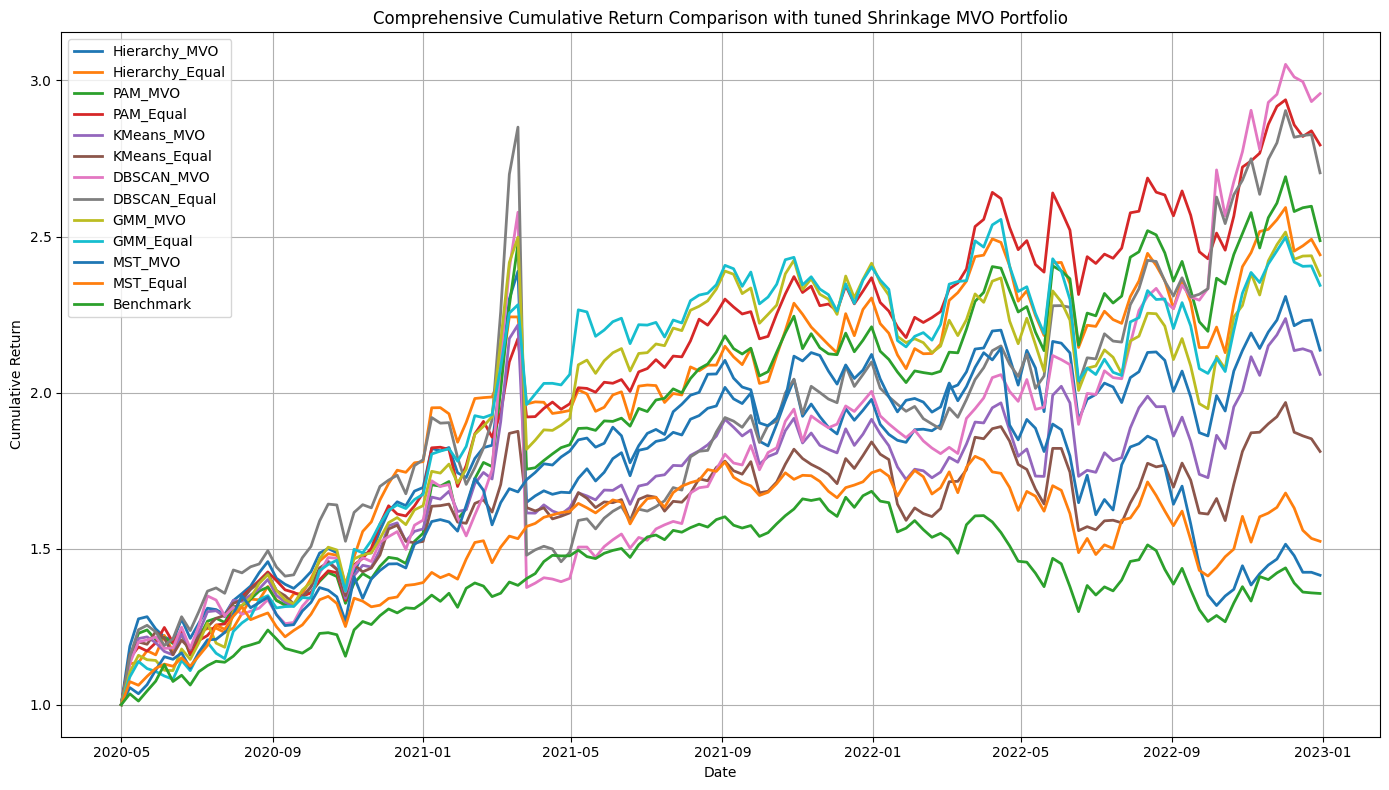


📊 Strategy Performance Metrics:
       Strategy  Annualized Sharpe  Annualized Volatility  Max Drawdown  Annualized Sortino  CAGR  Calmar Ratio
      PAM_Equal              1.662                  0.244        -0.124               2.618 0.465         3.750
Hierarchy_Equal              1.383                  0.259        -0.146               2.144 0.393         2.686
      GMM_Equal              1.283                  0.269        -0.203               1.852 0.372         1.836
     DBSCAN_MVO              1.204                  0.417        -0.466               1.102 0.496         1.063
        PAM_MVO              1.197                  0.323        -0.291               1.298 0.403         1.382
        GMM_MVO              1.143                  0.323        -0.272               1.328 0.379         1.393
   DBSCAN_Equal              1.111                  0.427        -0.489               0.996 0.447         0.915
  Hierarchy_MVO              0.989                  0.340        -0.310

In [ ]:
# =======================================
# Plotting and Evaluation
# =======================================
# Plotting
all_series = (
    olivia_mvo_returns + olivia_eq_returns +
    pam_mvo_returns + pam_eq_returns +
    kathy_mvo_returns['KMeans'] + kathy_eq_returns['KMeans'] +
    kathy_mvo_returns['DBSCAN'] + kathy_eq_returns['DBSCAN'] +
    kathy_mvo_returns['GMM']    + kathy_eq_returns['GMM']    +
    weihang_mst_mvo_returns     + weihang_mst_eq_returns
)
full_index = pd.concat(all_series).index.unique().sort_values()
cum_df = pd.DataFrame(index=full_index)

def add_strategy(df, name, series_list):
    if series_list:
        series = pd.concat(series_list).sort_index().fillna(0)
        df[name] = (1 + series).cumprod()

add_strategy(cum_df, 'Hierarchy_MVO', olivia_mvo_returns)
add_strategy(cum_df, 'Hierarchy_Equal', olivia_eq_returns)
add_strategy(cum_df, 'PAM_MVO', pam_mvo_returns)
add_strategy(cum_df, 'PAM_Equal', pam_eq_returns)
add_strategy(cum_df, 'KMeans_MVO', kathy_mvo_returns['KMeans'])
add_strategy(cum_df, 'KMeans_Equal', kathy_eq_returns['KMeans'])
add_strategy(cum_df, 'DBSCAN_MVO', kathy_mvo_returns['DBSCAN'])
add_strategy(cum_df, 'DBSCAN_Equal', kathy_eq_returns['DBSCAN'])
add_strategy(cum_df, 'GMM_MVO', kathy_mvo_returns['GMM'])
add_strategy(cum_df, 'GMM_Equal', kathy_eq_returns['GMM'])
add_strategy(cum_df, 'MST_MVO', weihang_mst_mvo_returns)
add_strategy(cum_df, 'MST_Equal', weihang_mst_eq_returns)

benchmark_series = (1 + benchmark_weekly_returns).reindex(full_index).fillna(method='ffill')
cum_df['Benchmark'] = benchmark_series.cumprod()
cum_df = cum_df / cum_df.iloc[0]

plt.figure(figsize=(14, 8))
for col in cum_df.columns:
    plt.plot(cum_df.index, cum_df[col], label=col, linewidth=2)
plt.title("Comprehensive Cumulative Return Comparison with tuned Shrinkage MVO Portfolio")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

metrics = []
for col in cum_df.columns:
    cum = cum_df[col]
    ret = cum.pct_change().dropna()

    sr = sharpe_ratio(ret)
    srt = sortino_ratio(ret)
    vol = volatility(ret)
    mdd = max_drawdown(cum)
    growth = cagr(cum)
    calmar = growth / abs(mdd) if mdd != 0 else np.nan

    metrics.append([col, sr, vol, mdd, srt, growth, calmar])

metrics_df = pd.DataFrame(metrics, columns=[
    "Strategy", "Annualized Sharpe", "Annualized Volatility", "Max Drawdown",
    "Annualized Sortino", "CAGR", "Calmar Ratio"
])

metrics_df = metrics_df.sort_values(by="Annualized Sharpe", ascending=False)

print("\n📊 Strategy Performance Metrics:")
print(metrics_df.to_string(index=False, float_format="%.3f"))

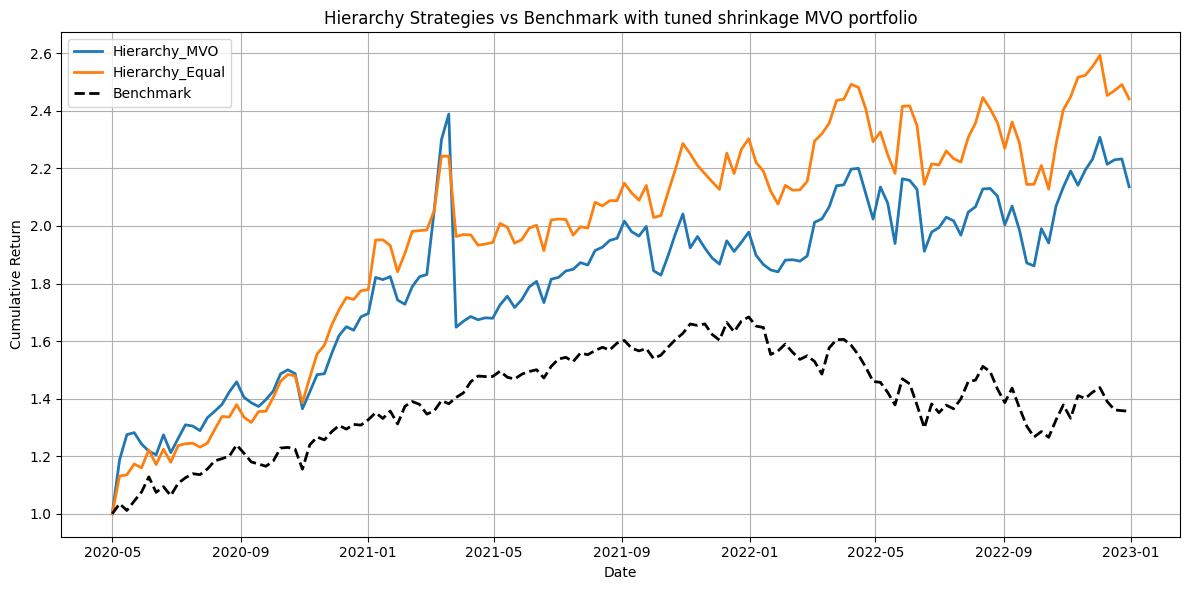

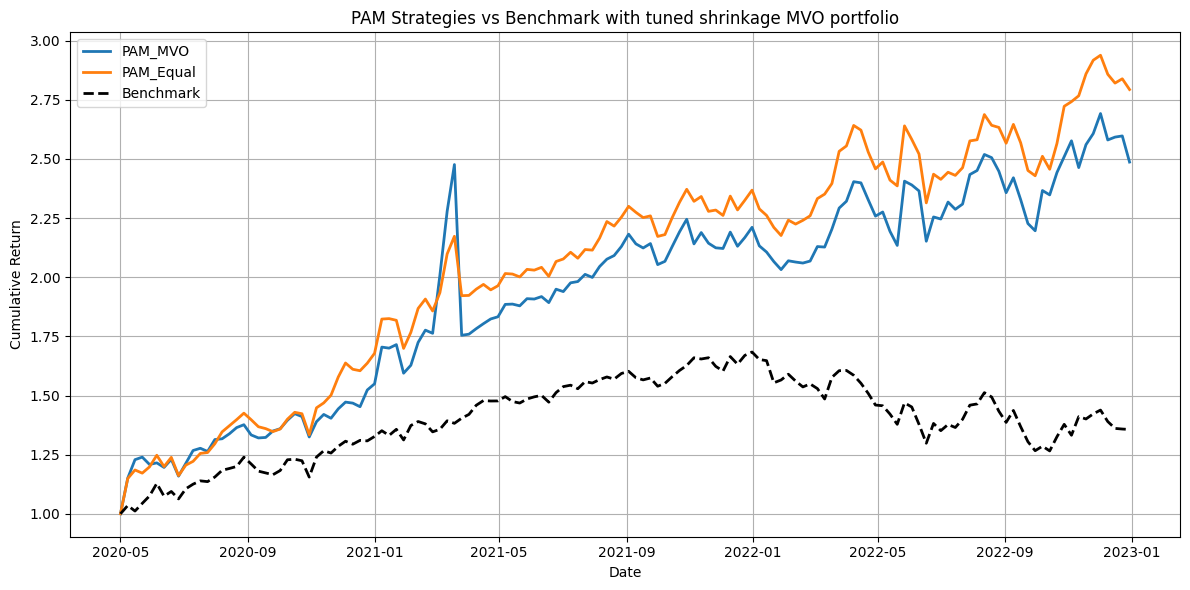

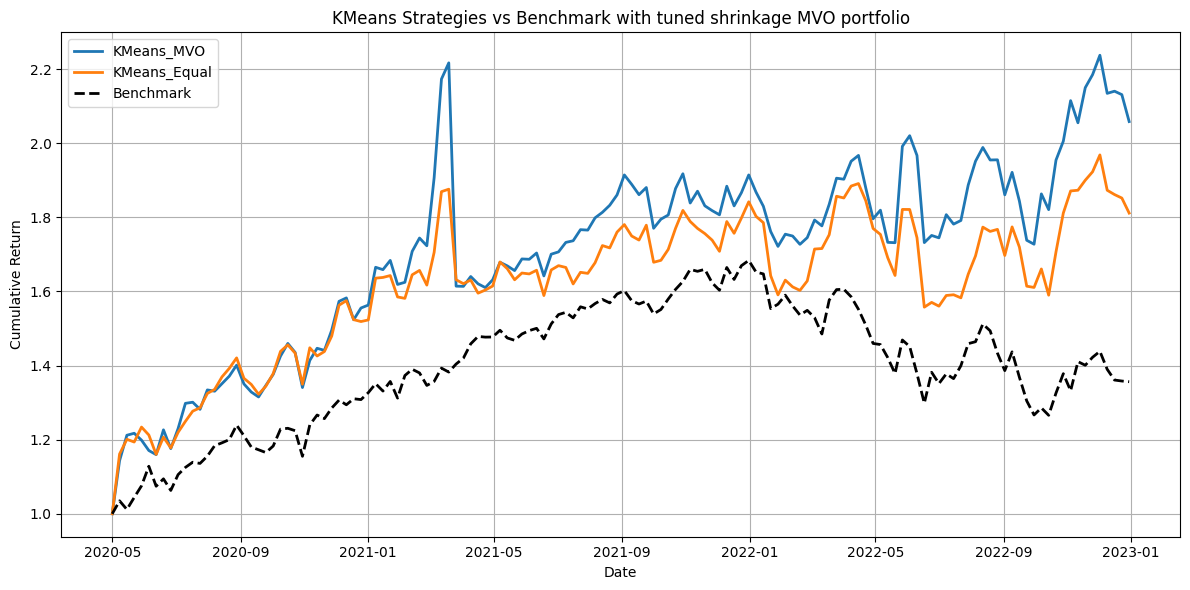

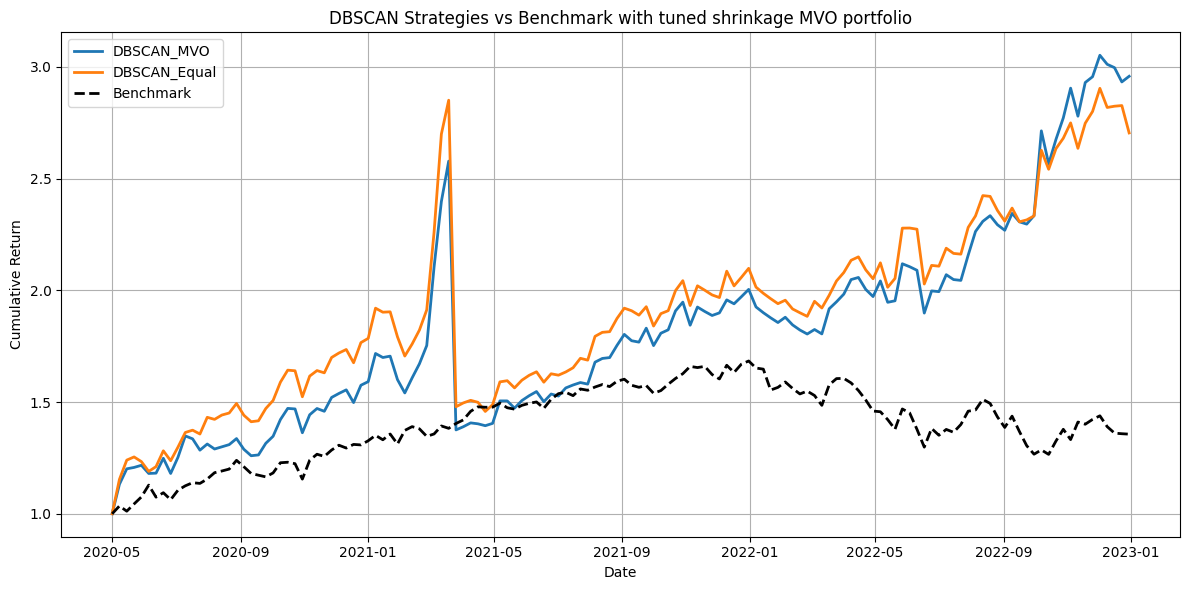

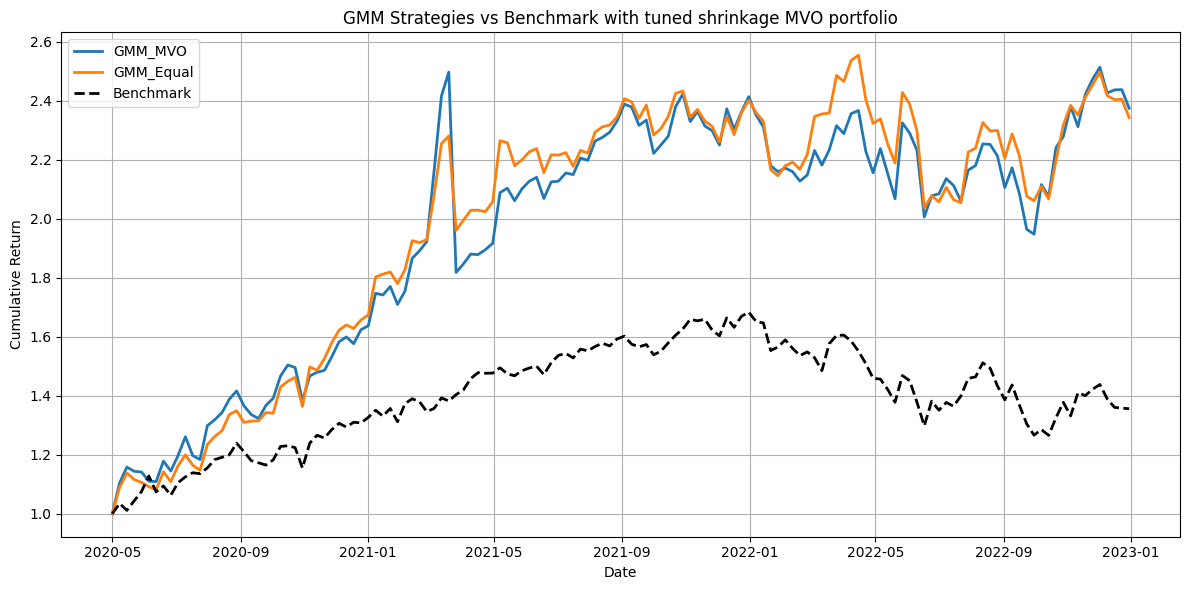

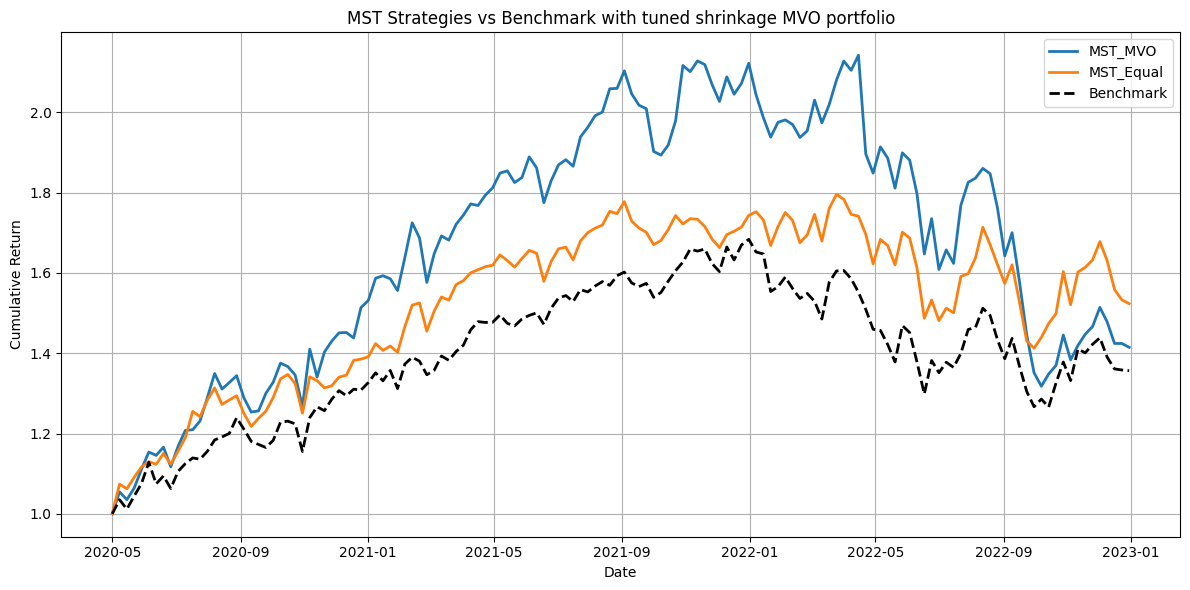

In [ ]:
# === Group strategies ===
plot_groups = {
    "Hierarchy": ["Hierarchy_MVO", "Hierarchy_Equal"],

    "PAM": ["PAM_MVO", "PAM_Equal"],
    "KMeans": ["KMeans_MVO", "KMeans_Equal"],
    "DBSCAN": ["DBSCAN_MVO", "DBSCAN_Equal"],
    "GMM": ["GMM_MVO", "GMM_Equal"],
    "MST": ["MST_MVO", "MST_Equal"],
}

benchmark_series = cum_df['Benchmark']

for group_name, strategies in plot_groups.items():
    plt.figure(figsize=(12, 6))
    for strategy in strategies:
        if strategy in cum_df.columns:
            plt.plot(cum_df.index, cum_df[strategy], label=strategy, linewidth=2)
    plt.plot(cum_df.index, benchmark_series, label="Benchmark", linestyle='--', color='black', linewidth=2)

    plt.title(f"{group_name} Strategies vs Benchmark with tuned shrinkage MVO portfolio")
    plt.xlabel("Date")
    plt.ylabel("Cumulative Return")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

#### Tuned shrinkage-ES Portfolio (CVaR)

In [ ]:
# =======================================
# Full Strategy Backtest with Tuned Shrinkage-ES Portfolio (CVaR)
# =======================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import NearestNeighbors
from scipy.cluster.hierarchy import linkage, fcluster
from kneed import KneeLocator
from sklearn.covariance import LedoitWolf
from scipy.stats import norm
import cvxpy as cp


def expected_shortfall_opt(returns_df, alpha=0.95):
    returns_df = returns_df.dropna(axis=1, how='any')
    if returns_df.shape[1] < 2 or returns_df.shape[0] < 4:
        return None

    # Apply Ledoit-Wolf shrinkage to returns for de-noising
    lw = LedoitWolf()
    lw.fit(returns_df)
    cleaned_returns = lw.location_ + (returns_df - returns_df.mean())

    T, n = cleaned_returns.shape
    returns_matrix = cleaned_returns.to_numpy()

    w = cp.Variable(n)
    z = cp.Variable(T)
    eta = cp.Variable()

    portfolio_returns = returns_matrix @ w
    loss = -portfolio_returns

    constraints = [
        cp.sum(w) == 1,
        w >= 0,
        z >= 0,
        z >= loss - eta
    ]

    obj = eta + (1 / ((1 - alpha) * T)) * cp.sum(z)
    prob = cp.Problem(cp.Minimize(obj), constraints)

    try:
        prob.solve()
        if w.value is None:
            return None
        return np.array(w.value)
    except:
        return None



In [ ]:
# =======================================
# Portfolio Construction
# =======================================
n_clusters = 4
rolling_window = 3
month_ends = weekly_returns.index.to_period('M').to_timestamp('M').unique()
methods = ['KMeans', 'DBSCAN', 'GMM']

olivia_mvo_returns, olivia_eq_returns = [], []
for i in range(rolling_window, len(month_ends) - 1):
    train_start, train_end = month_ends[i-rolling_window] + timedelta(days=1), month_ends[i]
    test_start, test_end = month_ends[i] + timedelta(days=1), month_ends[i+1]
    train_data = weekly_returns.loc[train_start:train_end]
    test_data = weekly_returns.loc[test_start:test_end]
    if train_data.empty or test_data.empty: continue

    train_matrix = train_data.T
    labels = fcluster(linkage(StandardScaler().fit_transform(train_matrix), method='ward'), t=n_clusters, criterion='maxclust')
    cluster_labels = pd.Series(labels, index=train_matrix.index)
    sharpe_df = pd.DataFrame({'Ticker': train_matrix.index, 'Sharpe': [sharpe_ratio(train_data[t]) for t in train_matrix.index]})
    top_stocks = pd.merge(cluster_labels.rename('Cluster'), sharpe_df, left_index=True, right_on='Ticker').sort_values('Sharpe', ascending=False).groupby('Cluster').head(2)
    valid = [t for t in top_stocks['Ticker'] if t in test_data.columns and t in train_data.columns]
    if len(valid) < 2: continue

    w = expected_shortfall_opt(train_data[valid])
    if w is not None:
        olivia_mvo_returns.append(test_data[valid] @ w)
        olivia_eq_returns.append(test_data[valid].mean(axis=1))



In [ ]:
# PAM implementation
top_n_per_cluster = 2
pam_mvo_returns = []
pam_eq_returns = []

for i in range(rolling_window, len(month_ends) - 1):
    train_start, train_end = month_ends[i-rolling_window] + timedelta(days=1), month_ends[i]
    test_start, test_end = month_ends[i] + timedelta(days=1), month_ends[i+1]
    train_data = weekly_returns.loc[train_start:train_end]
    test_data = weekly_returns.loc[test_start:test_end]

    if train_data.empty or test_data.empty:
        print(f"Skipped period {train_start.date()} - {train_end.date()}: Empty train/test data")
        continue

    if train_data.shape[0] < 4 or train_data.shape[1] < n_clusters:
        print(f"Skipped period {train_start.date()} - {train_end.date()}: Not enough time points or stocks")
        continue

    train_matrix = train_data.T
    scaled = StandardScaler().fit_transform(train_matrix)

    if scaled.shape[0] < n_clusters:
        print(f"Skipped period {train_start.date()} - {train_end.date()}: Too few stocks for clustering")
        continue

    try:
        initial_medoids = random.sample(range(scaled.shape[0]), n_clusters)
        distance_matrix = calculate_distance_matrix(scaled)
        pam_instance = kmedoids(distance_matrix, initial_medoids, data_type='distance_matrix')
        pam_instance.process()
        clusters = pam_instance.get_clusters()

        labels = np.empty(scaled.shape[0], dtype=int)
        for cluster_id, cluster in enumerate(clusters, start=1):
            for idx in cluster:
                labels[idx] = cluster_id
    except Exception as e:
        print(f"Clustering failed: {e}")
        continue

    cluster_labels = pd.Series(labels, index=train_matrix.index, name='Cluster')

    sharpe_df = pd.DataFrame({
        'Ticker': train_matrix.index,
        'Sharpe': [sharpe_ratio(train_data[t]) for t in train_matrix.index]
    })

    cluster_df = cluster_labels.rename_axis('Ticker').reset_index()
    combined_df = pd.merge(cluster_df, sharpe_df, on='Ticker')

    top_stocks = combined_df.sort_values(by='Sharpe', ascending=False).groupby('Cluster').head(top_n_per_cluster)

    selected_tickers = top_stocks['Ticker'].tolist()
    valid_tickers = [t for t in selected_tickers if t in train_data.columns and t in test_data.columns]

    if len(valid_tickers) < 2:
        print(f"Skipped period {train_start.date()} - {train_end.date()}: Not enough valid tickers ({len(valid_tickers)})")
        continue

    train_subset = train_data[valid_tickers]
    test_subset = test_data[valid_tickers]

    try:
        weights = expected_shortfall_opt(train_subset) ##
        weighted_returns = test_subset @ weights
        equal_returns = test_subset.mean(axis=1)

        pam_mvo_returns.append(weighted_returns)
        pam_eq_returns.append(equal_returns)
    except Exception as e:
        print(f"Optimization failed: {e}")
        continue

In [ ]:
kathy_mvo_returns = {m: [] for m in methods}
kathy_eq_returns = {m: [] for m in methods}
for i in range(rolling_window, len(month_ends) - 1):
    train_start, train_end = month_ends[i-rolling_window] + timedelta(days=1), month_ends[i]
    test_start, test_end = month_ends[i] + timedelta(days=1), month_ends[i+1]
    train, test = weekly_returns.loc[train_start:train_end], weekly_returns.loc[test_start:test_end]
    if train.shape[0] < 4 or test.empty: continue

    feats = train.T
    Xs = StandardScaler().fit_transform(feats)
    wcss = [KMeans(n_clusters=k, random_state=0, n_init=5).fit(Xs).inertia_ for k in range(1, 11)]
    k_opt = KneeLocator(range(1, 11), wcss, curve="convex", direction="decreasing").elbow or 4
    nbrs = NearestNeighbors(n_neighbors=3).fit(Xs)
    dists, _ = nbrs.kneighbors(Xs)
    d = np.sort(dists[:, 2])
    eps_opt = KneeLocator(range(len(d)), d, curve="convex", direction="increasing").knee or np.percentile(d, 90)

    labels = pd.DataFrame(index=feats.index)
    labels['KMeans'] = KMeans(n_clusters=k_opt, random_state=0, n_init=5).fit_predict(Xs)
    labels['DBSCAN'] = DBSCAN(eps=eps_opt, min_samples=3).fit_predict(Xs)
    labels['GMM'] = GaussianMixture(n_components=k_opt, random_state=0).fit(Xs).predict(Xs)

    sharpe = train.mean() / train.std(ddof=1) * np.sqrt(52)

    for m in methods:
        picks = set()
        for c in np.unique(labels[m]):
            if c == -1: continue
            members = labels.index[labels[m] == c]
            picks.update(sharpe.loc[members].nlargest(2).index)
        valid = [t for t in picks if t in train.columns and t in test.columns]
        if len(valid) < 2: continue

        w = expected_shortfall_opt(train[valid])
        if w is not None:
            kathy_mvo_returns[m].append(test[valid] @ w)
            kathy_eq_returns[m].append(test[valid].mean(axis=1))



In [ ]:
#Rolling-window MST strategy
weihang_mst_mvo_returns, weihang_mst_eq_returns = [], []
mst_selected_tickers = []
for i in range(rolling_window, len(month_ends) - 1):
    train_start = month_ends[i-rolling_window] + timedelta(days=1)
    train_end   = month_ends[i]
    test_start  = month_ends[i] + timedelta(days=1)
    test_end    = month_ends[i+1]
    train = weekly_returns.loc[train_start:train_end]
    test  = weekly_returns.loc[test_start:test_end]
    if train.empty or test.empty or train.shape[0] < 4:
        continue
    #build MST on train
    corr   = train.corr().values
    dist   = np.sqrt(2*(1-corr))
    mst    = minimum_spanning_tree(dist)
    coo    = mst.tocoo()
    #average edge-weight per node
    node_w = {n:[] for n in range(train.shape[1])}
    for u,v,w in zip(coo.row, coo.col, coo.data):
        node_w[u].append(w); node_w[v].append(w)
    avg_w = np.array([np.mean(node_w[n]) if node_w[n] else 0
                      for n in range(train.shape[1])])
    #pick top-11
    top_idx = np.argsort(avg_w)[-11:]
    tickers_sel = train.columns[top_idx]
    mst_selected_tickers.append(list(tickers_sel))
    #Equal-weight returns
    weihang_mst_eq_returns.append(test[tickers_sel].mean(axis=1))
    #MVO on those 11
    try:
        w = expected_shortfall_opt(train[tickers_sel])
        weihang_mst_mvo_returns.append(test[tickers_sel] @ w)
    except:
        continue

C:\Users\guoqi\AppData\Local\Temp\ipykernel_37848\2357058581.py:34: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  benchmark_series = (1 + benchmark_weekly_returns).reindex(full_index).fillna(method='ffill')


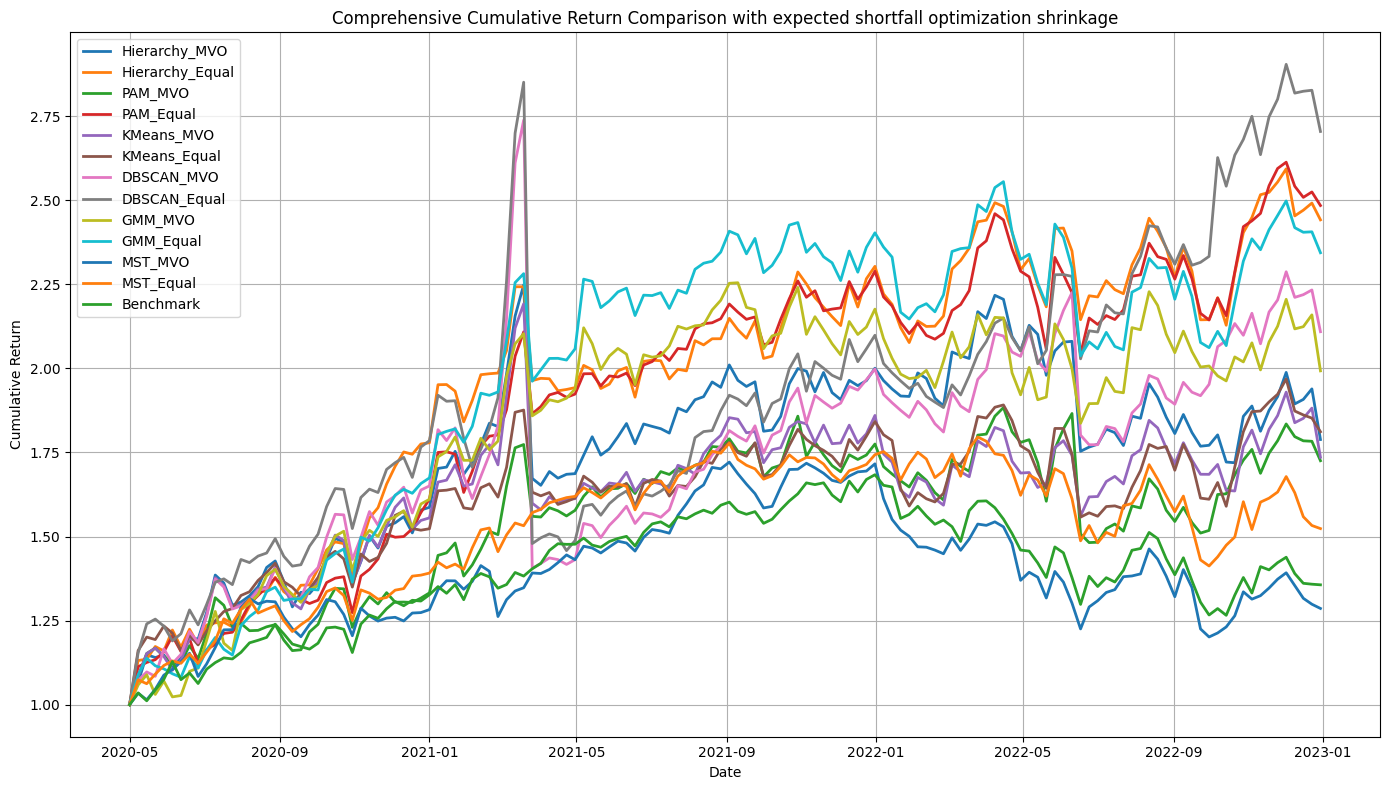


📊 Strategy Performance Metrics:
       Strategy  Annualized Sharpe  Annualized Volatility  Max Drawdown  Annualized Sortino  CAGR  Calmar Ratio
      PAM_Equal              1.477                  0.244        -0.170               2.169 0.402         2.371
Hierarchy_Equal              1.383                  0.259        -0.146               2.144 0.393         2.686
      GMM_Equal              1.283                  0.269        -0.203               1.852 0.372         1.836
   DBSCAN_Equal              1.111                  0.427        -0.489               0.996 0.447         0.915
        GMM_MVO              1.009                  0.286        -0.185               1.667 0.292         1.575
   KMeans_Equal              0.931                  0.266        -0.176               1.389 0.247         1.400
     DBSCAN_MVO              0.886                  0.437        -0.487               0.800 0.319         0.656
        PAM_MVO              0.843                  0.277        -0.213

In [ ]:
# =======================================
# Plotting and Evaluation
# =======================================
# Plotting
all_series = (
    olivia_mvo_returns + olivia_eq_returns +
    pam_mvo_returns + pam_eq_returns +
    kathy_mvo_returns['KMeans'] + kathy_eq_returns['KMeans'] +
    kathy_mvo_returns['DBSCAN'] + kathy_eq_returns['DBSCAN'] +
    kathy_mvo_returns['GMM']    + kathy_eq_returns['GMM']    +
    weihang_mst_mvo_returns     + weihang_mst_eq_returns
)
full_index = pd.concat(all_series).index.unique().sort_values()
cum_df = pd.DataFrame(index=full_index)

def add_strategy(df, name, series_list):
    if series_list:
        series = pd.concat(series_list).sort_index().fillna(0)
        df[name] = (1 + series).cumprod()

add_strategy(cum_df, 'Hierarchy_MVO', olivia_mvo_returns)
add_strategy(cum_df, 'Hierarchy_Equal', olivia_eq_returns)
add_strategy(cum_df, 'PAM_MVO', pam_mvo_returns)
add_strategy(cum_df, 'PAM_Equal', pam_eq_returns)
add_strategy(cum_df, 'KMeans_MVO', kathy_mvo_returns['KMeans'])
add_strategy(cum_df, 'KMeans_Equal', kathy_eq_returns['KMeans'])
add_strategy(cum_df, 'DBSCAN_MVO', kathy_mvo_returns['DBSCAN'])
add_strategy(cum_df, 'DBSCAN_Equal', kathy_eq_returns['DBSCAN'])
add_strategy(cum_df, 'GMM_MVO', kathy_mvo_returns['GMM'])
add_strategy(cum_df, 'GMM_Equal', kathy_eq_returns['GMM'])
add_strategy(cum_df, 'MST_MVO', weihang_mst_mvo_returns)
add_strategy(cum_df, 'MST_Equal', weihang_mst_eq_returns)

benchmark_series = (1 + benchmark_weekly_returns).reindex(full_index).fillna(method='ffill')
cum_df['Benchmark'] = benchmark_series.cumprod()
cum_df = cum_df / cum_df.iloc[0]

plt.figure(figsize=(14, 8))
for col in cum_df.columns:
    plt.plot(cum_df.index, cum_df[col], label=col, linewidth=2)
plt.title("Comprehensive Cumulative Return Comparison with expected shortfall optimization shrinkage")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

metrics = []
for col in cum_df.columns:
    cum = cum_df[col]
    ret = cum.pct_change().dropna()

    sr = sharpe_ratio(ret)
    srt = sortino_ratio(ret)
    vol = volatility(ret)
    mdd = max_drawdown(cum)
    growth = cagr(cum)
    calmar = growth / abs(mdd) if mdd != 0 else np.nan

    metrics.append([col, sr, vol, mdd, srt, growth, calmar])

metrics_df = pd.DataFrame(metrics, columns=[
    "Strategy", "Annualized Sharpe", "Annualized Volatility", "Max Drawdown",
    "Annualized Sortino", "CAGR", "Calmar Ratio"
])

metrics_df = metrics_df.sort_values(by="Annualized Sharpe", ascending=False)

print("\n📊 Strategy Performance Metrics:")
print(metrics_df.to_string(index=False, float_format="%.3f"))


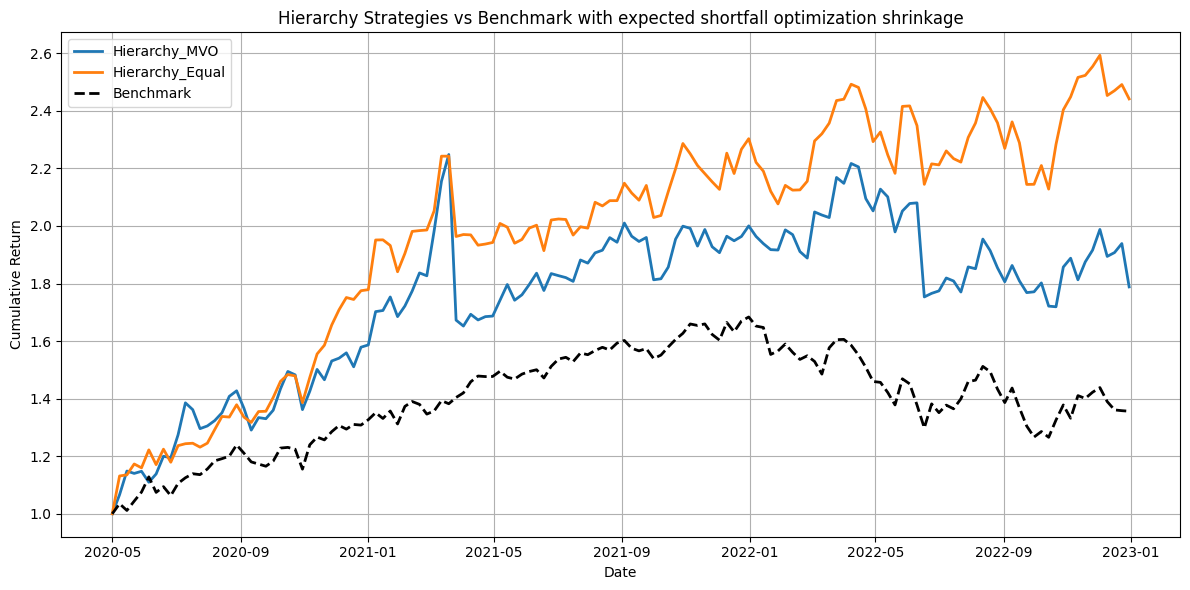

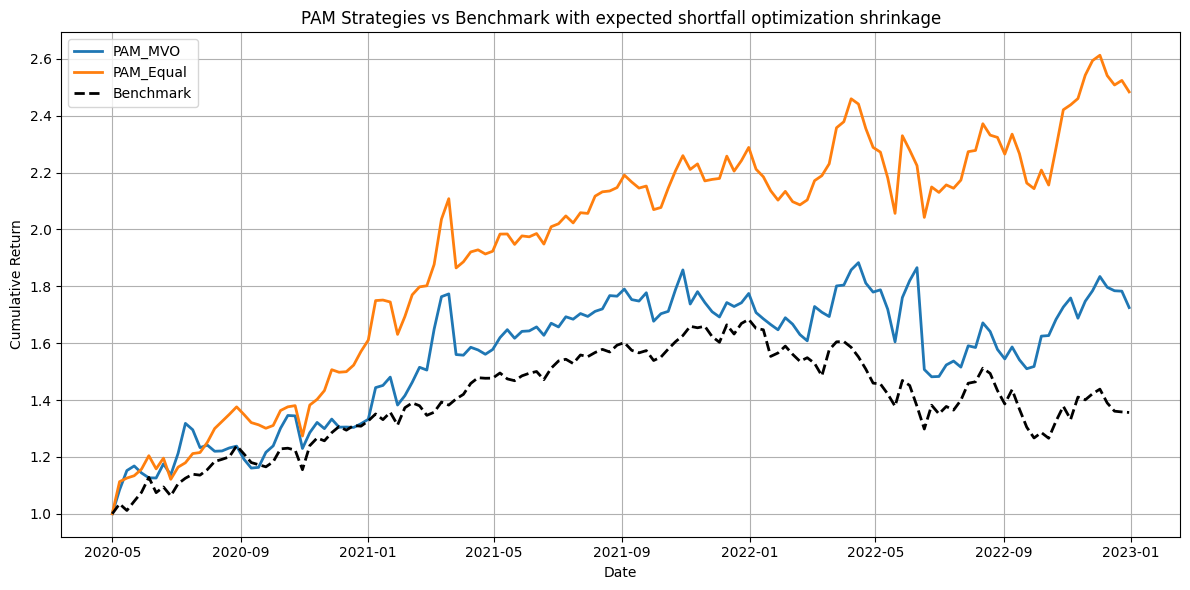

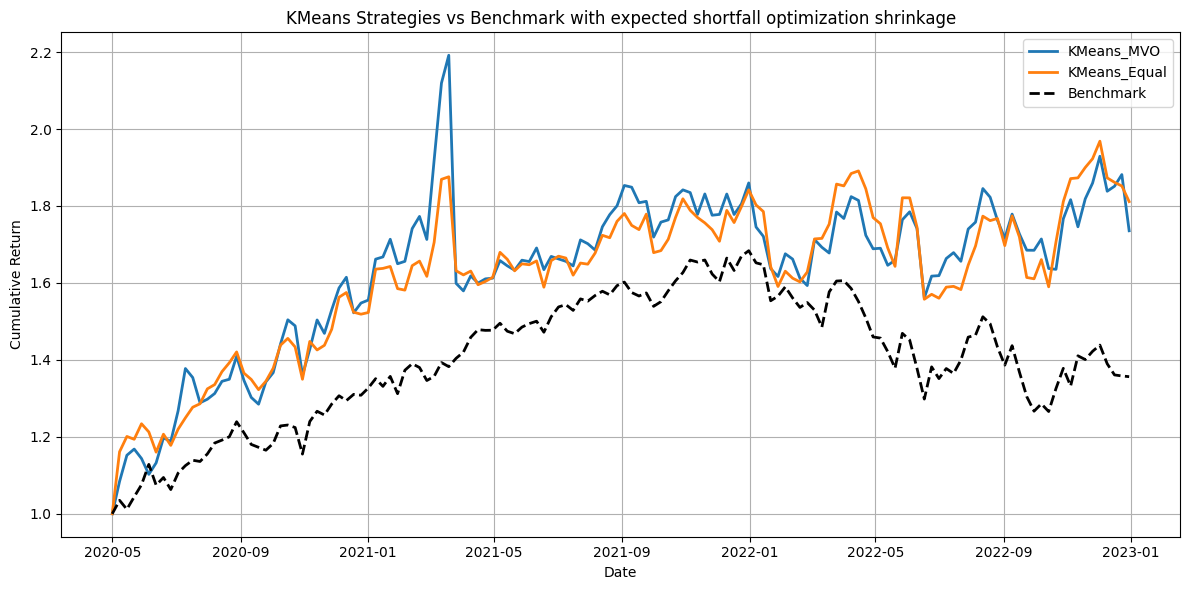

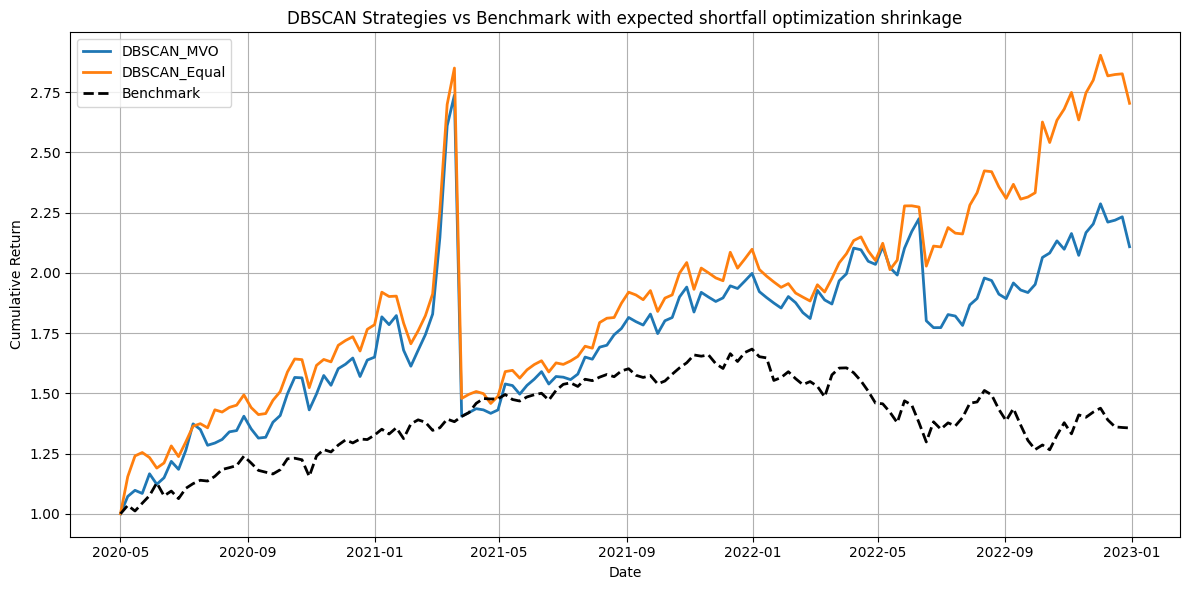

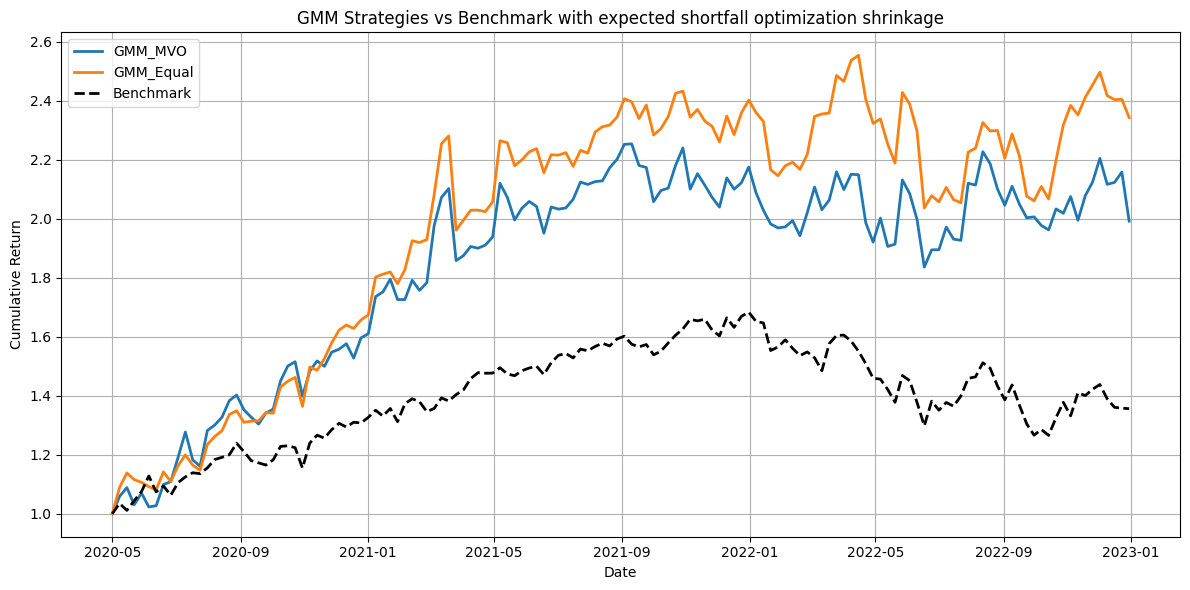

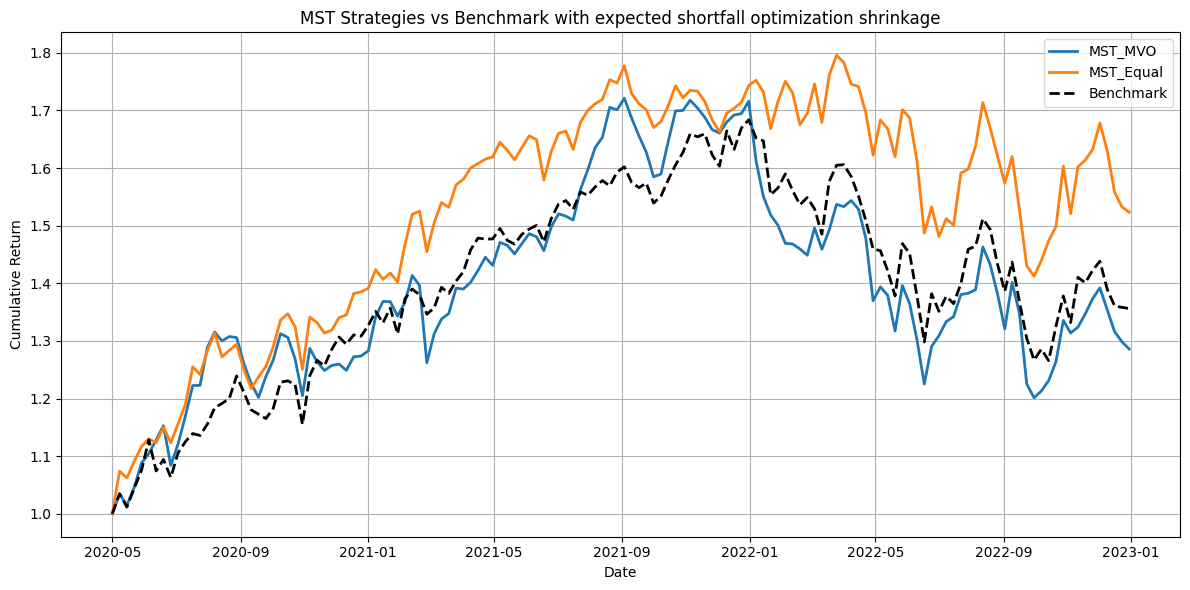

In [ ]:
# === Group strategies ===
plot_groups = {
    "Hierarchy": ["Hierarchy_MVO", "Hierarchy_Equal"],

    "PAM": ["PAM_MVO", "PAM_Equal"],
    "KMeans": ["KMeans_MVO", "KMeans_Equal"],
    "DBSCAN": ["DBSCAN_MVO", "DBSCAN_Equal"],
    "GMM": ["GMM_MVO", "GMM_Equal"],
    "MST": ["MST_MVO", "MST_Equal"],
}

benchmark_series = cum_df['Benchmark']

for group_name, strategies in plot_groups.items():
    plt.figure(figsize=(12, 6))
    for strategy in strategies:
        if strategy in cum_df.columns:
            plt.plot(cum_df.index, cum_df[strategy], label=strategy, linewidth=2)
    plt.plot(cum_df.index, benchmark_series, label="Benchmark", linestyle='--', color='black', linewidth=2)

    plt.title(f"{group_name} Strategies vs Benchmark with expected shortfall optimization shrinkage")
    plt.xlabel("Date")
    plt.ylabel("Cumulative Return")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()